In [5]:
from agents import TIME_LIMIT
# from creatures import vampire
# from creatures import leotris
from environments import square_room
from combat_handler import CombatHandler
from utils.agent_utils import calc_win_percentage

import dill
import numpy as np
import torch

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)


In [6]:
from agents import DoubleDQN
from agents import DoubleDuelingDQN
from agents import MCDoubleDuelingDQN
from agents import PPO
from agents import RangeAggression
from agents import RandomStrategy
from agents import SARSA

from actions import vampire_bite
from actions import arrow_shot
from actions import barbarian_axe_slash
from actions import cataclysm
from actions import EndTurn
from actions import MoveLeft
from actions import MoveRight
from actions import MoveUp
from actions import MoveDown
from actions import DoNotMove
from players import dungeon_master
from players import hayden
from utils.dnd_utils import roll_dice
from creatures import Creature

vampire = Creature(
    player=dungeon_master,
    name="Strahd",
    hit_points=200,
    armor_class=17,
    actions=[MoveLeft(), MoveRight(), MoveUp(), MoveDown(), DoNotMove(), barbarian_axe_slash],
    location=np.array([5, 5]),
    symbol="@",
    strategy=RandomStrategy()
)

leotris = Creature(
    player=hayden,
    name="Leotris",
    hit_points=200,
    armor_class=17,
    actions=[MoveLeft(), MoveRight(), MoveUp(), MoveDown(), DoNotMove(), barbarian_axe_slash],
    location=np.array([5, 10]),
    symbol="x",
    strategy=RandomStrategy()
)

# leotris = Creature(
#     player=hayden,
#     name="Leotris",
#     hit_points=250,
#     armor_class=16,
#     actions=[MoveLeft(), MoveRight(), MoveUp(), MoveDown(), DoNotMove(), barbarian_axe_slash],
#     location=np.array([5, 10]),
#     symbol="x",
#     strategy=PPO()
# )

In [7]:


def report_win_percentages(winner_list, num_games, combatants, total_rewards, last_states, num_actions_takens):
    """
    :return: None
    """
    win_percentages = calc_win_percentage(winner_list[-num_games:], combatants)
    last_states = torch.cat(last_states).data.numpy()
    print("Win percentages: {}\t".format(win_percentages))

    results = list(zip(winner_list[-num_games:], total_rewards[-num_games:], last_states, num_actions_takens))
    results = sorted(results, key=lambda x: -x[1])

    print("winner, avg_reward, last_state, num_actions_taken")
    for winner, avg_reward, last_state, num_actions_taken in results:
        print(" {}: {} ({}) \t\t{}".format(winner, avg_reward, last_state, num_actions_taken))
    print("----------------------\n")


def intialize_combatants(combatants, combat_handler):
    """
    :param combatants:
    :return:
    """
    [combatant.initialize(combat_handler) for combatant in combatants]


def main():
    """
    Todo: Provide main documentation/overview
    """
    print('Start')
    n_iters = int(500)

    winner_list = []
    total_rewards = []
    last_states = []
    num_actions_takens = []

    for i in range(n_iters):
#         if i%10==0:print(i)
        combat_handler = CombatHandler(
            environment=square_room,
            combatants=[leotris, vampire],
            time_limit=TIME_LIMIT
        )
        intialize_combatants([leotris, vampire], combat_handler=combat_handler)
        winner, total_reward, last_state, num_actions_taken = combat_handler.run()

        winner_list.append(winner)
        total_rewards.append(total_reward)
        last_states.append(last_state)
        num_actions_takens.append(num_actions_taken)

        if (i + 1) % 10 == 0:
            print(i+1 , " of ",n_iters)
            report_win_percentages(
                winner_list=winner_list,
                num_games=10,
                combatants=[leotris, vampire],
                total_rewards=total_rewards,
                last_states=last_states,
                num_actions_takens=num_actions_takens
            )
            last_states = []
            num_actions_takens = []

        # Save tabular Q
        if (i + 1) % 10 == 0:
            dill.dump(winner_list, open("results/winner_list_{}.pickle".format(leotris.strategy.name), "wb"))
#             dill.dump(leotris.strategy.policy_net, open("results/model_{}.pickle".format(leotris.strategy.name), "wb"))
            dill.dump(total_rewards, open('results/reward_list_{}.pickle'.format(leotris.strategy.name), "wb"))


In [8]:
main()

Start
10  of  500
Win percentages: [('Leotris', 0.7), ('Strahd', 0.3)]	
winner, avg_reward, last_state, num_actions_taken
 Leotris: 0 ([ 0.435 -0.025  0.4    0.8    0.3    0.2    1.     1.     0.373]) 		560
 Leotris: 0 ([ 0.155 -0.02   0.7    0.8    0.7    0.3    1.     0.667  0.384]) 		576
 Leotris: 0 ([ 0.395 -0.005  0.6    0.6    0.1    0.7    1.     0.333  0.307]) 		460
 Leotris: 0 ([ 0.335 -0.03   0.5    0.8    0.7    0.7    1.     0.333  0.275]) 		413
 Leotris: 0 ([ 0.3   -0.04   0.5    0.2    0.1    0.2    1.     0.333  0.315]) 		473
 Strahd: 0 ([-0.025  0.06   0.6    0.3    0.6    0.8    0.     1.     0.359]) 		539
 Strahd: 0 ([-0.015  0.18   0.5    0.7    0.6    0.5    0.     1.     0.32 ]) 		480
 Leotris: 0 ([0.12  0.    0.8   0.3   0.4   0.8   1.    0.833 0.373]) 		560
 Strahd: 0 ([-0.01  0.33  0.2   0.5   0.3   0.4   0.    1.    0.37]) 		555
 Leotris: 0 ([ 0.615 -0.03   0.5    0.6    0.5    0.5    1.     1.     0.338]) 		507
----------------------

20  of  500
Win percentag

KeyboardInterrupt: 

In [ ]:
# Check

In [6]:
import pandas as pd
import dill
from collections import Counter
from collections import defaultdict
from matplotlib import pyplot as plt
import torch
import numpy as np

In [7]:
def calc_win_percentage(winner_list, creatures):
    total_games_played = len(winner_list)
    counts = Counter(winner_list)
    win_percentages = {creature: num_wins/total_games_played for creature, num_wins in counts.items()}
    for creature in creatures:
        if creature not in win_percentages.keys():
            win_percentages[creature] = 0
    return win_percentages

def report_actions(state):
    action_names = [
        "end",
        "left",
        "right",
        "up",
        "down",
        "shot",
    ]

    try:
        dist, value = policy_net(state)
        action_probs = dist.probs.data.numpy()[0]
    except:
        action_probs = policy_net(state).detach().numpy().reshape(-1)


    actions = list(zip(action_names, action_probs))
    for an, a in actions:
        print("{}: \t{}".format(an, a))
    print("-----{}-----".format(
        action_names[int(np.argmax(action_probs))]
    ))


Number of games played: 500
0
creature plot


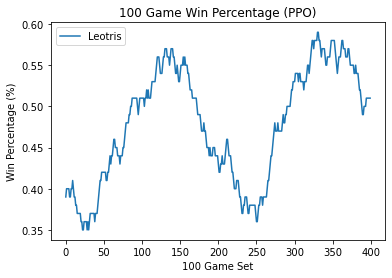

In [8]:
model_name = 'PPO'
winner_list = dill.load(open("results/winner_list_{}.pickle".format(model_name), "rb"))

batch_size = 100
win_pcts = defaultdict(list)
avg_rewards = list()

creatures = ["Leotris"]  #, "Strahd", "Timeout"]

print("Number of games played: {}".format(len(winner_list)))

# Graph win percentage:
for i in range(0, len(winner_list) - batch_size):
    if i%50000==0:print(i)
    batch_winner_list = winner_list[i:(i+batch_size)]
    win_pct = calc_win_percentage(batch_winner_list, creatures=creatures)
    for creature, batch_win_pct in win_pct.items():
        win_pcts[creature].append(batch_win_pct)
print('creature plot')
for creature in creatures:
    plt.plot(range(len(win_pcts[creature])), win_pcts[creature], label=creature)
plt.title("{} Game Win Percentage ({})".format(batch_size, model_name))
plt.ylabel("Win Percentage (%)")
plt.xlabel("{} Game Set".format(batch_size))
plt.legend()
plt.savefig('results/{}.png'.format(model_name))
plt.show()

# reward_list = dill.load(open("results/reward_list_{}.pickle".format(model_name), "rb"))
# # Graph reward:
# for i in range(0, len(reward_list) - batch_size):
#     batch_reward_list = reward_list[i:(i+batch_size)]
#     avg_reward = np.mean(batch_reward_list)
#     avg_rewards.append(avg_reward)
    
# plt.plot(range(len(avg_rewards)), avg_rewards)
# plt.title("Average Rewards")
# plt.ylabel("Average Reward")
# plt.xlabel("{} Game Set".format(batch_size))
# plt.show()